In [84]:
import json
from collections import defaultdict
from operator import itemgetter
import numpy as np
import joblib
import pandas as pd
import re
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

In [1]:
# folder of data
DATA_FOLDER = '../content'
# folder of processed data
PROCESSED_DATA_FOLDER = '../content/processed_data'
# path image format
IMAGE_FORMAT = '../content/%s/COCO_%s_%012d.jpg'

# 
MAX_ANSWERS = 1000 
# batch size
BATCH_SIZE = 300
# buffer size
BUFFER_SIZE = 5000

In [4]:
"""
    Annotation Format
    
    annotation{
    "question_id" : int,
    "image_id" : int,
    "question_type" : str,
    "answer_type" : str,
    "answers" : [answer],
    "multiple_choice_answer" : str
    }
    
    answer{
    "answer_id" : int,
    "answer" : str,
    "answer_confidence": str
    }
"""
tTrainAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_train2014_annotations.json', 'r'))
tValAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_val2014_annotations.json', 'r'))

"""
    Input Questions Format
    
    question{
    "question_id" : int,
    "image_id" : int,
    "question" : str
}

"""
tTrainQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
tValQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_val2014_questions.json', 'r'))

In [19]:
tTrainAnnotations

{'info': {'description': 'This is v2.0 of the VQA dataset.',
  'url': 'http://visualqa.org',
  'version': '2.0',
  'year': 2017,
  'contributor': 'VQA Team',
  'date_created': '2017-04-26 17:07:13'},
 'license': {'url': 'http://creativecommons.org/licenses/by/4.0/',
  'name': 'Creative Commons Attribution 4.0 International License'},
 'data_subtype': 'train2014',
 'annotations': [{'question_type': 'what is this',
   'multiple_choice_answer': 'net',
   'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
    {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
    {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
    {'answer': 'net', 'answer_confidence': 'yes', 'answer_

In [5]:
"""
    Function name: GetAllAnswer
    
    Objective: Join a list of answers by ";" to a single string
    
    Summary algorithmic description: Return a list of answers
    
    Input parameters: clAnswers: list of dictionaries of answers
    
    Return : list of answers of a question
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def GetAllAnswer(clAnswers):
    return ';'.join([cdAnswer['answer'] for cdAnswer in clAnswers])

In [6]:
"""
    Function name: ProcessQuestionAnnotation
    
    Objective: Creates a JSON file whose elements are (img_path, question, ans, answers)
    
    Summary algorithmic description: Loop over all annotations to read all elements
                                     Add every element to the list
                                     Save the list to a JSON file
    
    Input parameters: sDataFolder: "train2014" or "val2014"
    
    Return : None
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessQuestionAnnotation(sDataFolder):
    # Read input annotation data
    tAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_{sDataFolder}_annotations.json', 'r'))
    # Read input question data
    tQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_{sDataFolder}_questions.json', 'r'))
    # list of dictionaries whose keys are (img_path, question, ans, answers)
    clData = []

    # Loop over all annotations
    for iC in tqdm.tqdm(range(len(tAnnotations['annotations']))):
        # path image
        sImagePath = IMAGE_FORMAT%(sDataFolder, sDataFolder, tAnnotations['annotations'][iC]['image_id'])
        # question
        sQuestion = tQuestions['questions'][iC]['question']
        # answer
        sAns = tAnnotations['annotations'][iC]['multiple_choice_answer']
        # list of answers
        clAnswers = GetAllAnswer(tAnnotations['annotations'][iC]['answers'])
        # Add a element to the dictionary
        clData.append({'img_path': sImagePath, 'question': sQuestion, 'ans': sAns, 'answers': clAnswers})
    
    # save to disk
    json.dump(clData, open(f'{DATA_FOLDER}/vqa_raw_{sDataFolder}.json', 'w'))

In [7]:
# # Creates a JSON file whose elements are (img_path, question, ans, answers) for train data
# ProcessQuestionAnnotation("train2014")
# # Creates a JSON file whose elements are (img_path, question, ans, answers) for val data
# ProcessQuestionAnnotation("val2014")

In [8]:
# Read trainning data
tTrainData = json.load(open(f'{DATA_FOLDER}/vqa_raw_train2014.json', 'r'))
# Read validation data
tValData = json.load(open(f'{DATA_FOLDER}/vqa_raw_val2014.json', 'r'))

In [20]:
tTrainData

[{'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What is this photo taken looking through?',
  'ans': 'net',
  'answers': 'net;net;net;netting;net;net;mesh;net;net;net'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What position is this man playing?',
  'ans': 'pitcher',
  'answers': 'pitcher;catcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What color is the players shirt?',
  'ans': 'orange',
  'answers': 'orange;orange;orange;orange;orange;orange;orange;orange;orange;orange'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'Is this man a professional baseball player?',
  'ans': 'yes',
  'answers': 'yes;yes;yes;yes;yes;no;yes;yes;yes;yes'},
 {'img_path': '../content/train2014/COCO_train2014_000000262146.jpg',
  'question': 'What color is the snow?',
  'ans': 'whit

# Reduce dataset to top 1000 answers

In [13]:
# dictionary with key is a answer and value is number of this answer in the dataset
cdAnswerFreq = defaultdict(int)
# Loop over all answers in the trainning data
for sAnswer in list(map(itemgetter('ans'), tTrainData)):
    # number of this answer (sAnswer) inscrease
    cdAnswerFreq[sAnswer] += 1

# list of top 1000 most frequents answers as a tuple (answer, frequency)   
clSortedFreq = sorted(cdAnswerFreq.items(), key=itemgetter(1), reverse=True)[0: 1000]
# Produce tuples of top 1000 most frequents answers and top 1000 most frequencies
ctTopAnswers, ctTopFreq = zip(*clSortedFreq)

In [14]:
# Display number of different types of answers
print('There are total ', len(cdAnswerFreq), ' different types of answers.')

There are total  22531  different types of answers.


In [15]:
"""
    Function name: SelectTopAnswersData
    
    Objective: Reduces the train dataset to contain only the datapoints whose answer occurence is in top most frequents 
    
    Summary algorithmic description: Find the top most frequents answers
                                     Get all the datapoints whose answer occurence is in top most frequents 
    
    Input parameters: clQuestion: list of questions
                      clMostFreqAnswer : list of most frequent answer of a question
                      clAnswers : list of all possible answers of a question
                      clPathImage : list of path images
                      iNbTopAnswers : number of top answers 
    
    Return : tuple of reduced dataset and the top k answers
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def SelectTopAnswersData(clQuestion, clMostFreqAnswer, clAnswers, clPathImage, iNbTopAnswers):
    # dictionary with key is a answer and value is number of this answer in the dataset
    cdAnswerFreq= defaultdict(int)
    
    # Loop over all the most frequent answers of a image in the dataset
    for sAnswer in clMostFreqAnswer:
        # number of this answer (sAnswer) inscrease
        cdAnswerFreq[sAnswer] += 1

    # list of top most frequents answers as a tuple (answer, frequency) 
    cdSortedAnswerFreq = sorted(cdAnswerFreq.items(), key=itemgetter(1), reverse=True)[0: iNbTopAnswers]
    # Produce tuples of top most frequents answers and top most frequencies
    ctTopAnswer, ctTopFreqAnswer = zip(*cdSortedAnswerFreq)

    # list of questions whose answer is in the top most frequent answers
    clNewQuestion = []
    # list of top most frequents answers
    clNewMostFreqAnswer = []
    # list of all possible answers of a question whost the most frequent answer is in the top most frequent answers
    clNewAnswers = []
    # list of images whose answer is in the top most frequent answers
    clNewPathImage = []

    # Loop over all elements
    for sQuestion, sMostFreqAnswer, clAnswer, sPathImage in zip(clQuestion, clMostFreqAnswer, clAnswers, clPathImage):
        # if the most frequent answer of a image is in the top most frequents answers
        if sMostFreqAnswer in ctTopAnswer:
            # Add the question to the list
            clNewQuestion.append(sQuestion)
            # Add the most frequent answer of a image to the list
            clNewMostFreqAnswer.append(sMostFreqAnswer)
            # Add all possible answers of a question to the list
            clNewAnswers.append(clAnswer)
            # Add the path image to the list
            clNewPathImage.append(sPathImage)

    # Amount of data reduction 
    print('Data size reduced by', np.round(((len(clQuestion) - len(clNewQuestion)) / len(clQuestion)) * 100, 2), '%')
    # Return tuple of reduced dataset and the top k answers
    return(clNewQuestion, clNewMostFreqAnswer, clNewAnswers, clNewPathImage, ctTopAnswer)

In [18]:
# Reduce the train dataset to contain only the datapoints whose answer occurence is in top most frequents
clQuestionTrain, clAnswerTrain, clAnswersTrain, clPathImageTrain, ctTopAnswer = \
SelectTopAnswersData(list(map(itemgetter('question'), tTrainData)), 
                    list(map(itemgetter('ans'), tTrainData)), 
                    list(map(itemgetter('answers'), tTrainData)), 
                    list(map(itemgetter('img_path'), tTrainData)), 
                    MAX_ANSWERS)

Data size reduced by 12.53 %


In [25]:
"""
    Function name: FilterTopAnswersValData
    
    Objective: Reduces the validation dataset to contain only the datapoints whose answer occurence is in top most frequents 
    
    Summary algorithmic description: Find the top most frequents answers
                                     Get all the validation datapoints whose answer occurence is in top most frequents 
    
    Input parameters: clQuestion: list of questions
                      clMostFreqAnswer : list of most frequent answer of a question
                      clAnswers : list of all possible answers of a question
                      clPathImage : list of path images
                      iNbTopAnswers : number of top answers 
    
    Return : tuple of reduced dataset and the top k answers
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def FilterTopAnswersValData(clQuestion, clMostFreqAnswer, clAnswers, clPathImage, ctTopAnswer):
    # list of questions whose answer is in the top most frequent answers
    clNewQuestion = []
    # list of top most frequents answers
    clNewMostFreqAnswer = []
    # list of all possible answers of a question whost the most frequent answer is in the top most frequent answers
    clNewAnswers = []
    # list of images whose answer is in the top most frequent answers
    clNewPathImage = []

    # Loop over all elements
    for sQuestion, sMostFreqAnswer, clAnswer, sPathImage in zip(clQuestion, clMostFreqAnswer, clAnswers, clPathImage):
        # if the most frequent answer of a image is in the top most frequents answers
        if sMostFreqAnswer in ctTopAnswer:
            # Add the question to the list
            clNewQuestion.append(sQuestion)
            # Add the most frequent answer of a image to the list
            clNewMostFreqAnswer.append(sMostFreqAnswer)
            # Add all possible answers of a question to the list
            clNewAnswers.append(clAnswer)
            # Add the path image to the list
            clNewPathImage.append(sPathImage)

    # Amount of data reduction  
    print('Data size reduced by', np.round(((len(clQuestion) - len(clNewQuestion)) / len(clQuestion)) * 100, 2), '%')
    # Return tuple of reduced validation dataset and the top k answers
    return(clNewQuestion, clNewMostFreqAnswer, clNewAnswers, clNewPathImage)

In [26]:
# Reduce the validation dataset to contain only the datapoints whose answer occurence is in top most frequents 
clQuestionVal, clAnswerVal, clAnswersVal, clPathImageVal = \
FilterTopAnswersValData(list(map(itemgetter('question'), tValData)), 
                      list(map(itemgetter('ans'), tValData)),
                      list(map(itemgetter('answers'), tValData)), 
                      list(map(itemgetter('img_path'), tValData)), 
                     ctTopAnswer)

Data size reduced by 13.0 %


In [21]:
# # save to disk
# with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_train2014_top1000.json', 'wb') as f:
#     joblib.dump((clQuestionTrain, clAnswerTrain, clAnswersTrain, clPathImageTrain), f)

# with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_val2014_top1000.json', 'wb') as f:
#     joblib.dump((clQuestionVal, clAnswerVal, clAnswersVal, clPathImageVal), f)

In [24]:
# loading from disk
with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_train2014_top1000.json', 'rb') as f:
    clQuestionTrain, clAnswerTrain, clAnswersTrain, clPathImageTrain = joblib.load(f)

with open(f'{PROCESSED_DATA_FOLDER}/vqa_raw_val2014_top1000.json', 'rb') as f:
    clQuestionVal, clAnswerVal, clAnswersVal, clPathImageVal = joblib.load(f)

# Image features

In [27]:
"""
    Function name: ImageFeatureExtractor
    
    Objective: Extract (49, 512)-dimensional CNN features by fine-tuning VGG19 and save them locally 
    
    Summary algorithmic description: Load pre-trained model VGG19, don't add final layer
                                     Pass the pprecessed images through the network and use the outputs as our actual features
                                     Save image features to image id folder
    
    Input parameters: sPathFeature: path to save the features
                      clImageFilename : list of image filenames
                      iBatchSize : batch size
    
    Return : None
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ImageFeatureExtractor(sPathFeature, clImageFilename, iBatchSize):
    # Load pre-trained model graph, don't add final layer
    model = VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

    # add a progress bar
    progbar = utils.Progbar(int(np.ceil(len(clImageFilename) / float(iBatchSize))))

    # loop over the images in batches
    for (iCounter, iBSize) in enumerate(range(0, len(clImageFilename), iBatchSize)):
        # extract batch of images and prepare them to pass it through the VGG 
        # network for feature extraction

        # Update the progress bar.
        progbar.update(iCounter+1)

        # range of batch
        itBatchRange = range(iBSize, min(iBSize + iBatchSize, len(clImageFilename)))
        # batch of image filenames
        clBatchImageFilename = clImageFilename[itBatchRange[0]: itBatchRange[-1]+1]

        # list of processed images
        clBatchImage = []
        # list of image ids 
        clBatchId = []
        # loop over the images in the current batch
        for sImageFilename in clBatchImageFilename:

            # load the input image, while ensuring the image is resized to 224x224 pixels
            img = image.load_img(f'{DATA_FOLDER}/train2014/' + sImageFilename, target_size=(224, 224))
            # Convert a PIL Image instance to a Numpy array.
            caImg = image.img_to_array(img)

            # expand the dimensions to include batch dim
            caImg = np.expand_dims(caImg, axis=0)
            # The image are converted from RGB to BGR, then each color channel is zero-centered 
            # with respect to the ImageNet dataset, without scaling.
            caImg = preprocess_input(caImg)

            # add the image to the batch
            clBatchImage.append(caImg)
            # Add the image id of the batch to the list of ids
            clBatchId.append(sImageFilename.split('.')[0][-6:])

        # Stack image arrays in sequence vertically (BATCH_SIZE, 224, 224, 3)
        clBatchImage = np.vstack(clBatchImage) 

        # Pass the images through the network and use the outputs as our actual features (BATCH_SIZE, 7, 7, 512)
        tsFeatures = model.predict(clBatchImage) 
        # Reshapes the features (BATCH_SIZE, 49, 512)
        tsFeatures = tf.reshape(tsFeatures, (tsFeatures.shape[0], -1, tsFeatures.shape[-1])) 

        # Loop over the batch to save them locally
        for sId, tsFeature in zip(clBatchId, tsFeatures):
            # Save image features to image id folder 
            np.save(os.path.join(sPathFeature, sId), tsFeature)

In [28]:
# clImageFilenameTrain = os.listdir(f'{DATA_FOLDER}/train2014')

In [29]:
# ImageFeatureExtractor(f'{DATA_FOLDER}/features', clImageFilenameTrain, BATCH_SIZE)

# Text features

In [30]:
# contraction mappings
CONTRACTIONS = {"aint": "ain't", "arent": "aren't", "cant": "can't", 
                "couldve": "could've", "couldnt": "couldn't", "couldn'tve": "couldn't've", "couldnt've": "couldn't've", 
                "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", 
                "hadnt": "hadn't", "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", 
                "hed": "he'd", "hed've": "he'd've", "he'dve": "he'd've", "hes": "he's", 
                "howd": "how'd", "howll": "how'll", "hows": "how's", 
                "Id've": "I'd've", "I'dve": "I'd've", "Im": "I'm", "Ive": "I've", 
                "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", 
                "let's": "let's", 
                "maam": "ma'am", 
                "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", 
                "mustnt": "mustn't", "mustve": "must've", 
                "neednt": "needn't", "notve": "not've", 
                "oclock": "o'clock", 
                "oughtnt": "oughtn't", 
                "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", 
                "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", "she's": "she's", 
                "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", 
                "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", 
                "somebodyll": "somebody'll", "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", 
                "someone'dve": "someone'd've", "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", 
                "somethingd've": "something'd've", "something'dve": "something'd've", "somethingll": "something'll", 
                "thats": "that's", 
                "thered": "there'd", "thered've": "there'd've", "there'dve": "there'd've", "therere": "there're", 
                "theres": "there's", 
                "theyd": "they'd", "theyd've": "they'd've", "they'dve": "they'd've", "theyll": "they'll", 
                "theyre": "they're", "theyve": "they've", 
                "twas": "'twas", "wasnt": "wasn't", 
                "wed've": "we'd've", "we'dve": "we'd've", 
                "weve": "we've", "werent": "weren't", 
                "whatll": "what'll", "whatre": "what're", "whats": "what's", "whatve": "what've", 
                "whens": "when's", 
                "whered": "where'd", "where's": "where is", "whereve": "where've", 
                "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", 
                "whove": "who've", 
                "whyll": "why'll", "whyre": "why're", "whys": "why's", 
                "wont": "won't", 
                "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", "wouldn'tve": "wouldn't've", 
                "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", 
                "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", 
                "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", 
                "youll": "you'll", "youre": "you're", "youve": "you've"}

In [31]:
# list of punctuations to remove
PUNCTUATIONS = [';', r"/", '[', ']', '"', '{', '}',
                '(', ')', '=', '+', '\\', '_', '-',
                '*', ':', '^', '%', '$', '#', '&',
                '>', '<', '@', '`', ',', '?', '!']

In [32]:
"""
    Function name: ProcessSentence
    
    Objective: Clean a given raw sentence
    
    Summary algorithmic description: Remove redundant white spaces, punctuations
    
    Input parameters: sSentence: sentence to process
    
    Return : the cleaned version of the sentence
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessSentence(sSentence):
    # Remove the character ".", except from floating numbers
    oPeriodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    # Remove any "," between digits, eg: 5,6
    oCommaStrip   = re.compile("(\d)(\,)(\d)")

    # Replace new line with a white space
    sInText = sSentence.replace('\n', ' ')
    # Replace multiple white space with single white space
    sInText = sInText.replace('\t', ' ')
    # Remove leading and trailing whitespaces
    sInText = sInText.strip()
    # The result of process
    sOutText = sInText
    # Loop over all punctuations
    for p in PUNCTUATIONS:
        # If p + ' ' ou ' ' + p ou ',' between digits in the sentence
        if (p + ' ' in sInText or ' ' + p in sInText) or (re.search(oCommaStrip, sInText) != None):
            # All occurrences of p replaced by ''
            sOutText = sOutText.replace(p, '')
        # If not
        else:
            # Replace p by a white space 
            sOutText = sOutText.replace(p, ' ')
    # Replace the character "." by the ''.
    sOutText = oPeriodStrip.sub("", sOutText)
    # Convert the sentence to lowercase, then to a list of words
    sOutText = sOutText.lower().split()
    # Loop over the words
    for iWordId, sWord in enumerate(sOutText):
        # If the word is a contraction
        if sWord in CONTRACTIONS:
            # Convert it to the right format of the contraction
            sOutText[iWordId] = CONTRACTIONS[sWord]
    # Concatenate of all the words to a sentence
    sOutText = ' '.join(sOutText)
    # Return the cleaned version of the sentence
    return sOutText

In [37]:
# Clean all the questions in the training data
psQuestionTrainProcessed = pd.Series(clQuestionTrain).apply(ProcessSentence)
# Clean all the questions in the validation data
psQuestionValProcessed = pd.Series(clQuestionVal).apply(ProcessSentence)

In [38]:
# # save to disk
# with open(f'{PROCESSED_DATA_FOLDER}/processed_questions.pkl', 'wb') as f:
#     joblib.dump((psQuestionTrainProcessed, psQuestionValProcessed), f)

In [39]:
# load from disk
with open(f'{PROCESSED_DATA_FOLDER}/processed_questions.pkl', 'rb') as f:
    psQuestionTrainProcessed, psQuestionValProcessed = joblib.load(f)

## Tokenization

In [42]:
# Text tokenization class
oTok = text.Tokenizer(filters='')
# Update internal vocabulary based on a list of questions.
oTok.fit_on_texts(psQuestionTrainProcessed)

In [43]:
# # save to disk
# with open(f'{DATA_FOLDER}/text_tokenizer.pkl', 'wb') as f:
#     joblib.dump(oTok, f)

In [44]:
# load from disk
with open(f'{DATA_FOLDER}/text_tokenizer.pkl', 'rb') as f:
    oTok = joblib.load(f)

In [49]:
# Transform each trainning question to a sequence of integers.
clQuestionTrainTokenized = oTok.texts_to_sequences(psQuestionTrainProcessed)
# Transform each validation question to a sequence of integers.
clQuestionValTokenized = oTok.texts_to_sequences(psQuestionValProcessed)

In [50]:
clQuestionTrainTokenized

[[3, 2, 5, 24, 66, 90, 460],
 [3, 555, 2, 5, 14, 56],
 [3, 12, 2, 1, 281, 52],
 [2, 5, 14, 7, 364, 368, 194],
 [3, 12, 2, 1, 187],
 [3, 2, 1, 23, 31],
 [3, 12, 2, 1, 1049, 6039],
 [3, 2, 6, 1, 255, 91],
 [2, 1, 44, 394],
 [2, 1, 44, 90, 41, 7, 207, 135, 25, 271],
 [2, 1, 74, 159],
 [2, 13, 187, 9, 1, 472],
 [2, 1, 156, 152],
 [3, 2, 1, 121, 31],
 [2, 86, 1314],
 [2, 1, 14, 358],
 [15, 45, 226, 1716, 534, 70, 45, 550],
 [15, 1, 14, 67, 175],
 [2, 5, 24, 6, 12],
 [2, 1, 14, 19, 7, 1480, 226],
 [2657, 89, 1, 446, 79, 5, 66, 6, 7, 7781, 676, 277],
 [3, 151, 4, 63, 6, 5, 17],
 [4, 1, 94, 9, 1, 457],
 [79, 5, 24, 66, 473],
 [15, 1, 192, 22, 7, 1345],
 [3, 2, 5, 14, 110, 9],
 [8, 10, 1682, 39, 35, 120, 9, 5, 61, 520],
 [3, 12, 2, 45, 133],
 [2, 1, 61, 1608, 3362, 45, 265, 524, 1494],
 [3, 12, 2, 1, 266],
 [2, 1, 14, 110, 9, 7, 878, 1440],
 [3, 2, 1, 14, 110, 9],
 [3, 2, 9, 1, 722],
 [8, 10, 459, 11, 646, 54, 4, 182, 46, 323, 4, 709, 6, 5, 17],
 [4, 1, 314, 1084, 6, 7, 7782, 12],
 [2, 1, 559, 

C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


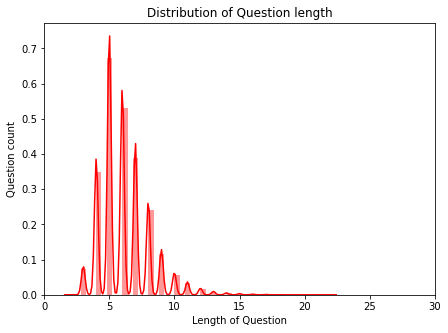

In [55]:
# list of lengths of question token
clQuestionTokenLength = [len(clToken) for clToken in clQuestionTrainTokenized]
# Create a new figure
plt.figure(figsize=(7,5))
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(clQuestionTokenLength, color='red')
# Set a title for the figure
plt.title('Distribution of Question length')
# Set the label for the x-axis
plt.xlabel('Length of Question')
# Set the label for the y-axis
plt.ylabel('Question count')
# Set the x-axis limits
plt.xlim(0, 30)
# Display the figure
plt.show()

In [56]:
for iC in range(0, 11):
    # Compute the q-th percentile of the token length
    print(10 * iC,'percentile value is', np.percentile(clQuestionTokenLength, 10 * iC))

0 percentile value is 2.0
10 percentile value is 4.0
20 percentile value is 5.0
30 percentile value is 5.0
40 percentile value is 5.0
50 percentile value is 6.0
60 percentile value is 6.0
70 percentile value is 7.0
80 percentile value is 7.0
90 percentile value is 8.0
100 percentile value is 22.0


In [57]:
for iC in range(0,11):
    # Compute the q-th percentile of the token length
    print(90 + iC,'percentile value is', np.percentile(clQuestionTokenLength, 90 + iC))

90 percentile value is 8.0
91 percentile value is 9.0
92 percentile value is 9.0
93 percentile value is 9.0
94 percentile value is 9.0
95 percentile value is 10.0
96 percentile value is 10.0
97 percentile value is 10.0
98 percentile value is 11.0
99 percentile value is 12.0
100 percentile value is 22.0


In [59]:
# maximum question length
MAX_QUESTION_LENGTH = 22

In [64]:
# Pad sequences to the same length
caQuestionTrainTokenized = sequence.pad_sequences(clQuestionTrainTokenized, maxlen=MAX_QUESTION_LENGTH, padding='post')
# Pad sequences to the same length
caQuestionValTokenized = sequence.pad_sequences(clQuestionValTokenized, maxlen=MAX_QUESTION_LENGTH, padding = 'post')

In [65]:
caQuestionTrainTokenized

array([[  3,   2,   5, ...,   0,   0,   0],
       [  3, 555,   2, ...,   0,   0,   0],
       [  3,  12,   2, ...,   0,   0,   0],
       ...,
       [  2,  13,   7, ...,   0,   0,   0],
       [  3,  12,   2, ...,   0,   0,   0],
       [  2,  50,   7, ...,   0,   0,   0]])

In [66]:
# # save to disk
# with open(f'{DATA_FOLDER}/tokenised_question_paddingPost.pkl', mode='wb') as f:
#     joblib.dump((clQuestionTrainTokenized, clQuestionValTokenized), f)

In [68]:
# load from disk
with open(f'{DATA_FOLDER}/tokenised_question_paddingPost.pkl', mode='rb') as f:
    caQuestionTrainTokenized, caQuestionValTokenized = joblib.load(f)

## Answers

In [73]:
# Encode target answers with value between 0 and n_classes-1
oLabelEncoder = preprocessing.LabelEncoder()
# Fit label encoder
oLabelEncoder.fit(clAnswerTrain)

LabelEncoder()

In [74]:
len(oLabelEncoder.classes_)

1000

In [75]:
# # save to disk
# with open(f'{DATA_FOLDER}/labelEncoder.pkl', 'wb') as f:
#     joblib.dump(oLabelEncoder, f)

In [76]:
# load from disk
with open(f'{DATA_FOLDER}/labelEncoder.pkl', 'rb') as f:
    oLabelEncoder = joblib.load(f)

C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Preparing the data matrices

In [77]:
"""
    Function name: GetAnswersMatrix
    
    Objective: One-hot-encode the answers
    
    Summary algorithmic description: Transform answers to normalized encoding.
                                     Convert the normalized encoding to one-hot-coding
    
    Input parameters: clAnswer : list of answers
                      cEncoder : LabelEncoder class
    
    Return : binary class matrix
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def GetAnswersMatrix(clAnswer, cEncoder):
    # Transform labels to normalized encoding.
    y = cEncoder.transform(clAnswer) 
    # Number of classes 
    iNbClasses = cEncoder.classes_.shape[0]
    # Convert a class vector (integers) to binary class matrix.
    Y = utils.to_categorical(y, iNbClasses)
    # Return the binary class matrix.
    return Y

In [80]:
# Stratified ShuffleSplit cross-validator
cStratifiedShuffleSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
# Generate indices to split data into training and test set
for caTrainIndex, caValIndex in cStratifiedShuffleSplit.split(clPathImageTrain, clAnswerTrain):
    TRAIN_INDEX = caTrainIndex
    VAL_INDEX = caValIndex

In [81]:
# trainning image data
caPathImageToTrain = np.array(clPathImageTrain)[TRAIN_INDEX.astype(int)] 
# validation image data
caPathImageToVal = np.array(clPathImageTrain)[VAL_INDEX.astype(int)]

# training question data
caQuestionTokenToTrain = caQuestionTrainTokenized[TRAIN_INDEX]
# validation image 
caQuestionTokenToVal = caQuestionTrainTokenized[VAL_INDEX]

In [82]:
caQuestionTokenToTrain

array([[  8,  10, 107, ...,   0,   0,   0],
       [  3,  12,   2, ...,   0,   0,   0],
       [  2,   5,   7, ...,   0,   0,   0],
       ...,
       [  2,  86,  19, ...,   0,   0,   0],
       [  3,  27,  11, ...,   0,   0,   0],
       [  3, 115,   2, ...,   0,   0,   0]])

In [85]:
# One-hot-encode the train answers 
caAnswerMatrix = GetAnswersMatrix(clAnswerTrain, cLabelEncoder)
# One-hot-coding Matrix for trainning and validation
caAnswerMatrixToTrain, caAnswerMatrixToVal = caAnswerMatrix[TRAIN_INDEX], caAnswerMatrix[VAL_INDEX]

In [86]:
caAnswerMatrix.shape

(388158, 1000)

In [87]:
caAnswerMatrixToTrain

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)